### Using a Pre-trained CNN to Detect Cyberbullying in Images

In [ ]:
 # download the model and dataset
!wget -O auxes_17.pt https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt # model checkpoints
!wget -O cyberbullying_data.zip https://github.com/cuadvancelab/materials/blob/main/lab2/cyberbullying_data.zip?raw=true # test dataset

--2025-03-10 02:24:32--  https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.box.com (buffalo.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to buffalo.box.com (buffalo.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2025-03-10 02:24:32--  https://buffalo.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Reusing existing connection to buffalo.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2025-03-10 02:24:33--  https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.app.box.com (buffalo.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to buffalo.app.box.com (buffalo.app.box.com)|74.112.186.157|:443... connected.
HTTP

In [ ]:
# unzip the test data
%%capture
!unzip "/content/cyberbullying_data.zip" -d "/content"

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

In [ ]:
import pickle
import gzip
import sys
import time
import numpy as np
import math
import os
import random
from skimage import io, transform

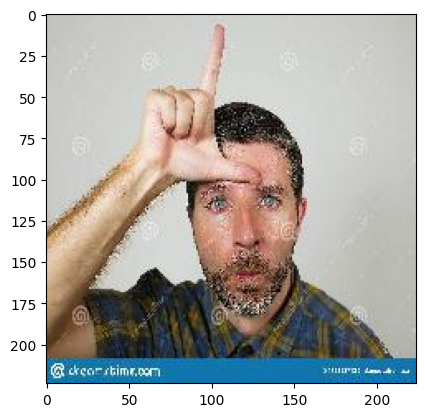

In [ ]:
# @title An example image
# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.image as img

# reading the image
testImage = img.imread('/content/cyberbullying_data/cyberbullying_data_splits_clean/test/cyberbullying/7.s-s-unshaven-sad-ashamed-man-doing-loser-sign-hand-fingers-his-front-funny-depressed-face-expression-s-139158713.jpg')

# displaying the image
plt.imshow(testImage)

**5 FACTORS to measurement cyberbulling in images**
- Body-pose
- Facial Emotion
- Object
- Gesture
- Social Factors

we aim to learn patterns based on pose data 

In [ ]:
class PosesDataset(Dataset):

  def __init__(self, root_dir, poses_dir, auxes_dir):

    self.samples = []
    self.root_dir = root_dir
    self.poses_dir = poses_dir
    self.auxes_dir = auxes_dir

    for _, _, cb_images in os.walk(self.root_dir + 'cyberbullying'): break
    for _, _, non_cb_images in os.walk(self.root_dir + 'non_cyberbullying'): break
    for _, _, cb_poses in os.walk(self.poses_dir + 'cyberbullying'): break
    for _, _, non_cb_poses in os.walk(self.poses_dir + 'non_cyberbullying'): break

    for i in cb_images:
      self.samples.append((self.root_dir + 'cyberbullying/' + i, self.poses_dir + 'cyberbullying/' + i, self.auxes_dir + 'cyberbullying/' + i, 1))

    for i in non_cb_images:
      self.samples.append((self.root_dir + 'non_cyberbullying/' + i, self.poses_dir + 'non_cyberbullying/' + i, self.auxes_dir + 'non_cyberbullying/' + i, 0))


  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name, pose_name, aux_name, label = self.samples[idx]
    image = io.imread(img_name)

    aux = pickle.load(open(aux_name + '.p', 'rb'))
    aux = torch.tensor(aux)

    # drop the alpha channel for some images
    if image.shape == (224, 224):
      # handle grayscale images
      image = np.stack([image, image, image], axis=2)

    if image.shape == (224, 224, 4):
      image = image[:,:,:3]

    image = image.transpose((2, 0, 1)) # C X H X W
    pose = io.imread(pose_name)
    if pose.shape != (224, 224):
      pose = pose[:,:,0]
    pose = np.expand_dims(pose, axis = 0)
    image = np.concatenate((image, pose), axis = 0)
    sample = {'image': torch.from_numpy(image.copy()).float() / 255, 'aux': aux, 'label': label}
    return sample

In [ ]:
test_set = PosesDataset('cyberbullying_data/cyberbullying_data_splits_clean/test/', 'cyberbullying_data/cyberbullying_poses/test/', 'cyberbullying_data/cyberbullying_data_auxes/test/')
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, shuffle = True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Let's load the pre-trained model to test its capability

In [ ]:
# load vgg16 pre-trained model
orig = models.vgg16(pretrained = True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 140MB/s]


In [ ]:
class CB(nn.Module):
  def __init__(self):
    super(CB, self).__init__()
    self.conv1 = nn.Conv2d(4, 3, 1)
    self.f = nn.Sequential(*list(orig.features.children()))
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.aux_classifier = nn.Sequential(
      nn.Linear(25097, 1024),
      nn.ReLU(),
      nn.Linear(1024, 25088),
      nn.ReLU()
    )
    self.classifier = nn.Sequential(*list(orig.classifier.children()))
    self.classifier[-1] = nn.Linear(4096, 2)
    self.sig = nn.Sigmoid()

  def forward(self, x, aux):
    x = self.conv1(x)
    x = self.f(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = torch.cat((x, aux), dim = 1)
    x = self.aux_classifier(x)
    x = self.classifier(x)
    x = self.sig(x)


    return x


In [ ]:
import torch

# Load model on CPU
model = torch.load("auxes_17.pt", map_location=torch.device('cpu'))
model.to(device)  # Ensure the model is on CPU
running_loss = []
criterion = nn.CrossEntropyLoss()
correct, incorrect, total = 0., 0., 0.

<ipython-input-57-e3feec8d0e7e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("auxes_17.pt", map_location=torch.device('cpu'))


In [ ]:
with torch.no_grad():
  for i_v, data_v in enumerate(test_loader):
    x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
    x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
    y_test_ = model(x_test, aux_test) # forward pass for the pre-trained model
    running_loss.append(criterion(y_test_, y_test))
    _, predicted = torch.max(y_test_.data, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()

print('Test loss is: {:.3f}'.format((sum(running_loss) / len(running_loss)).item()))
print('The accuracy for test dataset is: {:.3f}%'.format((correct / total) * 100))


Test loss is: 0.452
The accuracy for test dataset is: 85.000%


In [ ]:
# get the acc, precision, recall, f1 score for the test set

tp, tn, fp, fn = 0, 0, 0, 0

model.eval()
with torch.no_grad():
    for i_v, data_v in enumerate(test_loader):
        x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
        x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
        y_test_ = model(x_test, aux_test) # forward pass for the fine-tuned model
        _, predicted = torch.max(y_test_.data, 1)
        if y_test == 1 and predicted == 1:
            tp += 1
        elif y_test == 1 and predicted == 0:
            fn += 1
        elif y_test == 0 and predicted == 1:
            fp += 1
        elif y_test == 0 and predicted == 0:
            tn += 1

In [ ]:
acc = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

print('The accuracy for test dataset is: {}%'.format(acc * 100))
print('The precision for test dataset is: {}%'.format(precision * 100))
print('The recall for test dataset is: {}%'.format(recall * 100))
print('The f1 score for test dataset is: {}%'.format(f1 * 100))

The accuracy for test dataset is: 85.0%
The precision for test dataset is: 88.88888888888889%
The recall for test dataset is: 80.0%
The f1 score for test dataset is: 84.21052631578948%


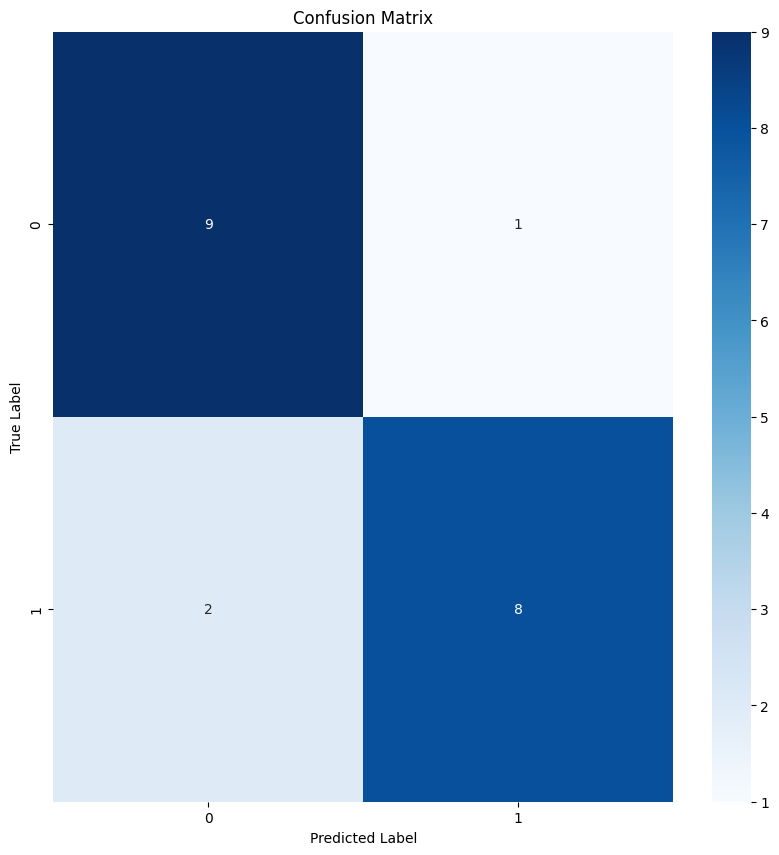

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    for i_v, data_v in enumerate(test_loader):
        x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
        x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype=torch.long), aux_test.to(device, dtype=torch.float)

        y_test_ = model(x_test, aux_test)  # Forward pass

        _, predicted = torch.max(y_test_.data, 1)

        # Store ground truth and predictions for later metric calculations
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# check how many test data samples we have
print(f"we have {len(test_set)} samples in our test dataset, you can choose any of them to see the prediction.")

we have 20 samples in our test dataset, you can choose any of them to see the prediction.


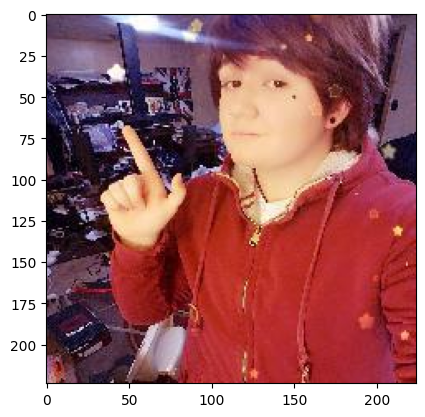


The label of this image is: cyberbullying


In [84]:
#@markdown Select a number to view the image and its label.

picture_index  = "5" #@param [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
index = int(picture_index)
instance = test_set[index]

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(test_set.samples[index][0])
imgplot = plt.imshow(img)
plt.show()
annot_label = "cyberbullying" if test_set[index]['label']==1 else "non-cyberbullying"
print('')
print("The label of this image is: {}".format(annot_label))

In [ ]:
# check if the prediction is correct
instance_image, instance_label, instance_aux = instance['image'].to(device), torch.tensor(instance['label']).to(device, dtype = torch.long), instance['aux'].to(device, dtype = torch.float)

output = model(instance_image.unsqueeze(0), instance_aux.unsqueeze(0)).data
_, prediction = torch.max(output.data, 1)
predict_label = "cyberbullying" if prediction.item()==1 else "non-cyberbullying"
comparision = "correct" if prediction==instance_label else "not correct"

print("The AI prediction for this image is: {}, which is {}!".format(predict_label, comparision))

The AI prediction for this image is: non-cyberbullying, which is not correct!


### Model Fine-Tuning

In [ ]:
# download the training data
!wget -O cyberbullying_train_data.zip https://buffalo.box.com/shared/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip

--2025-03-10 02:25:18--  https://buffalo.box.com/shared/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip
Resolving buffalo.box.com (buffalo.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to buffalo.box.com (buffalo.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip [following]
--2025-03-10 02:25:19--  https://buffalo.box.com/public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip
Reusing existing connection to buffalo.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://buffalo.app.box.com/public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip [following]
--2025-03-10 02:25:20--  https://buffalo.app.box.com/public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip
Resolving buffalo.app.box.com (buffalo.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to buffalo.app.box.com (buffalo.app.box.com)|74.112.186.157|:443... connected.

In [ ]:
# unzip the training data
%%capture
!unzip "/content/cyberbullying_train_data.zip" -d "/content"

In [ ]:
# prepare the training data
full_data = PosesDataset('cyberbullying_train_data/cyberbullying_data_splits_clean/train/', 'cyberbullying_train_data/cyberbullying_poses/train/', 'cyberbullying_train_data/cyberbullying_data_auxes/train/')
# remove .DS_Store files if they exist
full_data.samples = [x for x in full_data.samples if '.DS_Store' not in x[0]]
# prepare the dataloader
train_loader = torch.utils.data.DataLoader(full_data, batch_size = 12, shuffle = True)
from torch.utils.data import random_split, DataLoader

# Split into training (80%) and validation (20%) sets
train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size
train_set, val_set = random_split(full_data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=12, shuffle=True)
val_loader = DataLoader(val_set, batch_size=12, shuffle=False)

print(f"Training samples: {len(train_set)}, Validation samples: {len(val_set)}")


Training samples: 1934, Validation samples: 484


In [ ]:
# copy the pre-trained model for fine-tuning
ft_model = torch.load("auxes_17.pt",map_location=device)
ft_model.to(device)

<ipython-input-49-17f629a914ca>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load("auxes_17.pt",map_location=device)


CB(
  (conv1): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
  (f): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPo

In [ ]:
ft_model.train()

epochs = 15
best_val_loss = float("inf")

for epoch in range(epochs):
    # Reset counters for each epoch
    correct, incorrect, total = 0.0, 0.0, 0.0

    for i, data in enumerate(train_loader):
        inputs = data['image'].to(device)
        aux = data['aux'].to(device)
        labels = data['label'].to(device)
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = ft_model(inputs, aux)  # forward pass
        loss = criterion(outputs, labels)  # compute loss via comparing model's outputs and predefined labels
        loss.backward()  # backward pass
        optimizer.step()  # update weights
        running_loss.append(loss.item())  # save loss
        _, predicted = torch.max(outputs.data, 1)  # get predictions
        total += labels.size(0)  # update total
        correct += (predicted == labels).sum().item()  # update correct predictions
        incorrect += (predicted != labels).sum().item()  # update incorrect predictions (optional)

        if i % 50 == 0:  # print every 50 mini-batches
            accuracy = correct / total
            print(f'Epoch: {epoch}, Iteration: {i}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

    # Validation phase
    ft_model.eval()  # Set model to evaluation mode
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs = val_data['image'].to(device)
            val_aux = val_data['aux'].to(device)
            val_labels = val_data['label'].to(device)

            val_outputs = ft_model(val_inputs, val_aux)
            val_loss += criterion(val_outputs, val_labels).item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(ft_model.state_dict(), "best_model.pth")
        print("Model improved, saving new best model.")

Epoch: 0, Iteration: 0, Loss: 0.3651, Accuracy: 0.9167
Epoch: 0, Iteration: 50, Loss: 0.3623, Accuracy: 0.9510


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 0, Iteration: 100, Loss: 0.3942, Accuracy: 0.9530


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 0, Iteration: 150, Loss: 0.3966, Accuracy: 0.9581
Validation Loss: 0.3613, Validation Accuracy: 0.9483
Model improved, saving new best model.
Epoch: 1, Iteration: 0, Loss: 0.3161, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1, Iteration: 50, Loss: 0.4723, Accuracy: 0.9608


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1, Iteration: 100, Loss: 0.3957, Accuracy: 0.9571


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1, Iteration: 150, Loss: 0.3964, Accuracy: 0.9581
Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 2, Iteration: 0, Loss: 0.3952, Accuracy: 0.9167


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 2, Iteration: 50, Loss: 0.3917, Accuracy: 0.9657


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 2, Iteration: 100, Loss: 0.3317, Accuracy: 0.9546
Epoch: 2, Iteration: 150, Loss: 0.3160, Accuracy: 0.9558
Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 3, Iteration: 0, Loss: 0.3135, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3, Iteration: 50, Loss: 0.3688, Accuracy: 0.9559


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3, Iteration: 100, Loss: 0.3133, Accuracy: 0.9563


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3, Iteration: 150, Loss: 0.4498, Accuracy: 0.9575


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 4, Iteration: 0, Loss: 0.3138, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 4, Iteration: 50, Loss: 0.3589, Accuracy: 0.9673
Epoch: 4, Iteration: 100, Loss: 0.3142, Accuracy: 0.9571


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 4, Iteration: 150, Loss: 0.3274, Accuracy: 0.9564


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 5, Iteration: 0, Loss: 0.3136, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5, Iteration: 50, Loss: 0.3135, Accuracy: 0.9559


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5, Iteration: 100, Loss: 0.3133, Accuracy: 0.9546


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5, Iteration: 150, Loss: 0.3136, Accuracy: 0.9570


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 6, Iteration: 0, Loss: 0.3967, Accuracy: 0.9167


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 6, Iteration: 50, Loss: 0.3134, Accuracy: 0.9608


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 6, Iteration: 100, Loss: 0.4475, Accuracy: 0.9629


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 6, Iteration: 150, Loss: 0.3366, Accuracy: 0.9592


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 7, Iteration: 0, Loss: 0.3133, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 7, Iteration: 50, Loss: 0.3525, Accuracy: 0.9657


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 7, Iteration: 100, Loss: 0.3133, Accuracy: 0.9645


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 7, Iteration: 150, Loss: 0.3135, Accuracy: 0.9586
Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 8, Iteration: 0, Loss: 0.3158, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 8, Iteration: 50, Loss: 0.3136, Accuracy: 0.9624


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 8, Iteration: 100, Loss: 0.3136, Accuracy: 0.9612


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 8, Iteration: 150, Loss: 0.3966, Accuracy: 0.9570
Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 9, Iteration: 0, Loss: 0.3380, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 9, Iteration: 50, Loss: 0.3865, Accuracy: 0.9608


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 9, Iteration: 100, Loss: 0.3134, Accuracy: 0.9521


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 9, Iteration: 150, Loss: 0.3136, Accuracy: 0.9558
Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 10, Iteration: 0, Loss: 0.3973, Accuracy: 0.9167


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 10, Iteration: 50, Loss: 0.3133, Accuracy: 0.9575


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 10, Iteration: 100, Loss: 0.3950, Accuracy: 0.9596


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 10, Iteration: 150, Loss: 0.3966, Accuracy: 0.9581
Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 11, Iteration: 0, Loss: 0.3133, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 11, Iteration: 50, Loss: 0.3283, Accuracy: 0.9641


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 11, Iteration: 100, Loss: 0.3967, Accuracy: 0.9546


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 11, Iteration: 150, Loss: 0.3966, Accuracy: 0.9564


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 12, Iteration: 0, Loss: 0.4797, Accuracy: 0.8333


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 12, Iteration: 50, Loss: 0.3133, Accuracy: 0.9559


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 12, Iteration: 100, Loss: 0.3134, Accuracy: 0.9538


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 12, Iteration: 150, Loss: 0.3944, Accuracy: 0.9558


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 13, Iteration: 0, Loss: 0.3133, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 13, Iteration: 50, Loss: 0.3161, Accuracy: 0.9641


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 13, Iteration: 100, Loss: 0.3141, Accuracy: 0.9546
Epoch: 13, Iteration: 150, Loss: 0.3133, Accuracy: 0.9564


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Loss: 0.3613, Validation Accuracy: 0.9483
Epoch: 14, Iteration: 0, Loss: 0.3380, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 14, Iteration: 50, Loss: 0.3133, Accuracy: 0.9526


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 14, Iteration: 100, Loss: 0.3133, Accuracy: 0.9604
Epoch: 14, Iteration: 150, Loss: 0.4774, Accuracy: 0.9581


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Loss: 0.3613, Validation Accuracy: 0.9483


In [ ]:
trained_model = ft_model
trained_model.to(device)

# Load the best model (fine-tuned version)
state_dict = torch.load("best_model.pth", map_location=device)
trained_model.load_state_dict(state_dict)
trained_model.eval()

running_loss = 0.0  # To store the sum of individual losses
correct, total = 0, 0  # To store the count of correct predictions and total samples

with torch.no_grad():  # Disable gradient computation during evaluation
    for i_v, data_v in enumerate(test_loader):
        x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
        x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype=torch.long), aux_test.to(device, dtype=torch.float)

        # Forward pass for the fine-tuned model
        y_test_ = trained_model(x_test, aux_test)

        # Compute loss and accumulate
        loss = criterion(y_test_, y_test)
        running_loss += loss.item()  # Sum up loss for averaging

        # Get predictions
        _, predicted = torch.max(y_test_.data, 1)
        total += y_test.size(0)  # Accumulate total number of samples
        correct += (predicted == y_test).sum().item()  # Count correct predictions

# Calculate average loss
avg_loss = running_loss / len(test_loader)

# Calculate accuracy
accuracy = (correct / total) * 100

# Print results
print(f'Test Loss: {avg_loss:.3f}')
print(f'Test Accuracy: {accuracy:.2f}%')


<ipython-input-51-0d6a0e99a3ac>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_model.pth", map_location=device)


Test Loss: 0.452
Test Accuracy: 85.00%


Observations:

* VGG Model Test Accuracy: 85.0%, Test Loss: 0.450
* Fine-Tuned Model Test Accuracy: 85.0%, Test Loss: 0.452
* The fine-tuned model did not improve accuracy over the VGG model, and the test loss slightly increased.

Reasons for No Improvement:

* Insufficient Fine-Tuning: Learning rate or training epochs may not have been optimal.
* Overfitting: Fine-tuning might have overfitted to the training data.
* Task Simplicity: The task may not require further fine-tuning.
* Hyperparameters: Optimization settings might not be ideal for fine-tuning.

### Inference

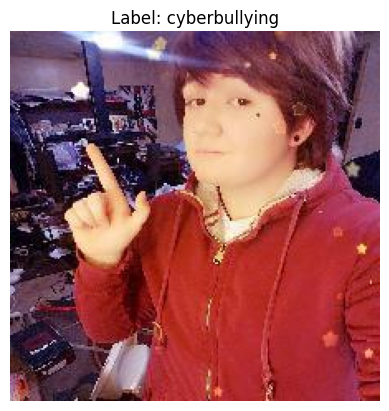

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the image
image_path = "/content/cyberbullying_data/cyberbullying_data_splits_clean/test/cyberbullying/fingerGunAnnotated_239.JPEG"
img = Image.open(image_path)

# Extract label from the path (assuming the label is the folder name)
label = os.path.basename(os.path.dirname(image_path))

# Plot the image with its label
plt.imshow(img)
plt.axis("off")  # Hide axes for better visualization
plt.title(f"Label: {label}")  # Display label as title
plt.show()


In [ ]:
picture_index = 5
instance = test_set[picture_index]

# check if the prediction is correct
instance_image, instance_label, instance_aux = instance['image'].to(device), torch.tensor(instance['label']).to(device, dtype = torch.long), instance['aux'].to(device, dtype = torch.float)
output = ft_model(instance_image.unsqueeze(0), instance_aux.unsqueeze(0)).data
_, prediction = torch.max(output.data, 1)
predict_label = "cyberbullying" if prediction.item()==1 else "non-cyberbullying"
comparision = "correct" if prediction==instance_label else "not correct"

print("The AI prediction for this image is: {}, which is {}!".format(predict_label, comparision))

The AI prediction for this image is: cyberbullying, which is correct!
